In [1]:
# 텐서플로우의 LinearRegressor 클래스를 사용하여 입력 특성 하나를 기반으로 
# 지역별 주택 중앙값을 예측한다
# 평균 제곱근 오차(RMSE)를 사용하여 모델 예측의 정확성을 평가한다
# 초매개변수를 조정하여 모델의 정확성을 개선한다

In [2]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [4]:
#확률적 경사하강법의 성능에 악영향을 줄 수 있는 의도치 않은 정렬 효과를 방지하고자 데이트를 무작위로 추출
california_housing_datafram=california_housing_dataframe.reindex(
np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"]/=1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66.9
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85.7
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73.4
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65.5
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111.4
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103.6
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85.8


In [5]:
# 데이터 조사
california_housing_datafram.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [6]:
#total_rooms을 입력값으로 정의
my_feature= california_housing_dataframe[["total_rooms"]]

#데이터가 숫자임을 지정
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [7]:
targets = california_housing_dataframe["median_house_value"]

In [8]:
# gradient descent를 사용해서 모델 학습시키기
# learning rate 인수는 경사 단계 크기 조절함
my_optimizer =tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer=tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

In [9]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
# linear_regressor로부터 train()을 호출하여 모델을 학습 시킬 수 있다.
_=linear_regressor.train(
    input_fn = lambda: my_input_fn(my_feature, targets),
    steps=100
)

In [11]:
# 예측할 입력 함수 만들기
# 학습 오차는 모델이 학습 데이터에 얼마나 맞춰졌는지 나타내는 척도로, 
# 새 데이터에 해당하는 정확도가 아니다

prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

predictions = linear_regressor.predict(input_fn=prediction_input_fn)

predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Sqaured Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Sqaured Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


In [12]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference= max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


In [13]:
# 예측과 타겟의 일치율 조사
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


In [14]:
#균일한 무작위 데이터 샘플 추출
sample=california_housing_dataframe.sample(n=300)

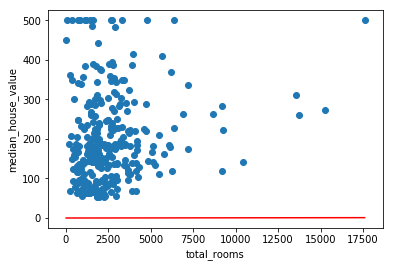

In [15]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [16]:
def train_model(learning_rate, steps, batch_size, input_feature):
  """Trains a linear regression model.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
      
  Returns:
    A Pandas `DataFrame` containing targets and the corresponding predictions done
    after training the model.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label].astype('float32')

  # Create input functions.
  training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])

    # Compute loss.
    root_mean_squared_error = math.sqrt(
      metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])

    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Create a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

    return calibration_data

Training model...
RMSE (on training data):
  period 00 : 212.91
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,27.5,207.3
std,12.8,116.0
min,6.1,15.0
25%,22.5,119.4
50%,27.1,180.4
75%,31.0,265.0
max,608.7,500.0


Final RMSE (on training data): 212.91


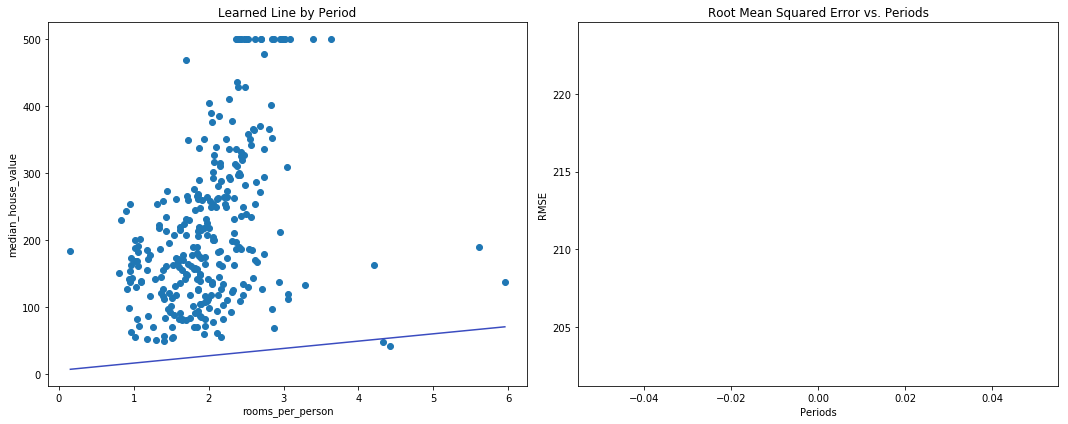

In [18]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

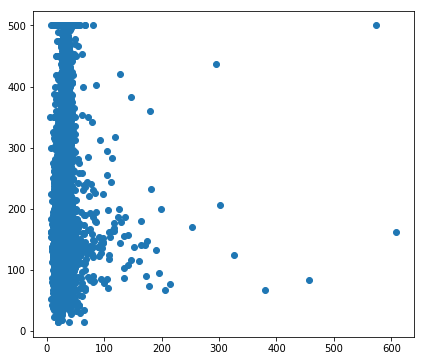

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(calibration_data["predictions"],calibration_data["targets"])

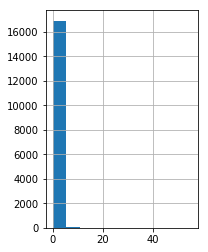

In [21]:
# _를 변수로 쓰면 마지막 변수 참조
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

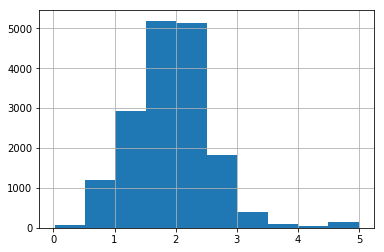

In [23]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

Training model...
RMSE (on training data):
  period 00 : 212.88
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,27.1,207.3
std,7.3,116.0
min,5.8,15.0
25%,22.5,119.4
50%,27.2,180.4
75%,31.1,265.0
max,61.2,500.0


Final RMSE (on training data): 212.88


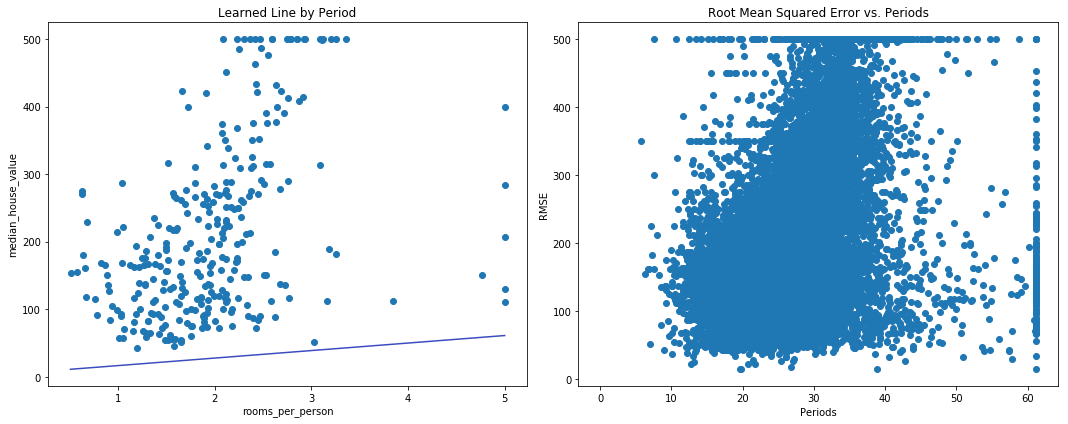

In [24]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])